<a target="_blank" href="https://colab.research.google.com/github/themis-ai/capsa/blob/main/notebooks/6_OOD_Detection.ipynb">
<img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

# Anomaly Detection (Advanced)

It is critical for a model to recognize that it is presented with an unreasonable input (e.g., OOD); in the real world this could be used for an autonomous vehicle yielding control to a human if the perception system detects that it is presented with such an input image as it is expected that model’s performance on this datapoint will be poor.  If we're sucessful in detecting such a distribution shift, model can pass this information downstream to avoid potentially disastrous prediction before it actually happens.

In this tutorial we will leverage the “uncertainty estimation” functionality provided by capsa for anomaly detection. 

In [ ]:
!pip install capsa

# download helper functions for this tutorial
!git clone --depth 1 https://github.com/themis-ai/capsa.git
!cd /content/capsa/notebooks/utils/depth

# download and extract datasets
!wget -q http://argo-1.themisai.io/demos/nyu_depth/nyu.h5
!wget -q http://6.869.csail.mit.edu/fa17/miniplaces/data.tar.gz
!mkdir miniplaces & tar -xzf data.tar.gz -C miniplaces

In [2]:
import tensorflow as tf
import config as config
from utils import notebook_select_gpu
notebook_select_gpu(1)

In [3]:
from utils import get_datasets
ds_train, ds_test, ds_ood = get_datasets(
    id_path = "nyu.h5",
    ood_path = "miniplaces",
)

## Train model

We'll use the same "base model" as in the previous tutorial (part 5). Let's also use  [EnsembleWrapper](https://themisai.io/capsa/api_documentation/EnsembleWrapper.html) to estimate epistemic uncertainty of the model. Same as with any other Capsa wrapper, user could simply wrap their model with it. This method of estimating the model uncertainty is accurate, although it's very computationally expensive. Luckily, capsa implements multiple different epistemic wrappers.

⭐ Please feel free to experiment and in the cell below instead of the EnsembleWrapper use one of the following ``Capsa`` epistemic wrappers: [DropoutWrapper](https://themisai.io/capsa/api_documentation/DropoutWrapper.html), [VAEWrapper](https://themisai.io/capsa/api_documentation/VAEWrapper.html).



In [4]:
from models import unet
from capsa import EnsembleWrapper

base_model = unet()

model = EnsembleWrapper(base_model, num_members=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LR),
    loss="mse",
)

In [5]:
history = model.fit(
    ds_train,
    epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20
256/256 [==============================] - 58s 202ms/step - usermodel_0_compiled_loss: 0.1357 - usermodel_1_compiled_loss: 0.0804 - usermodel_2_compiled_loss: 0.0921 - average_loss: 0.1027 - val_usermodel_0_compiled_loss: 0.0716 - val_usermodel_1_compiled_loss: 0.0539 - val_usermodel_2_compiled_loss: 0.0575
Epoch 2/20
256/256 [==============================] - 52s 205ms/step - usermodel_0_compiled_loss: 0.0611 - usermodel_1_compiled_loss: 0.0483 - usermodel_2_compiled_loss: 0.0508 - average_loss: 0.0534 - val_usermodel_0_compiled_loss: 0.0525 - val_usermodel_1_compiled_loss: 0.0431 - val_usermodel_2_compiled_loss: 0.0445
Epoch 3/20
256/256 [==============================] - 53s 206ms/step - usermodel_0_compiled_loss: 0.0465 - usermodel_1_compiled_loss: 0.0384 - usermodel_2_compiled_loss: 0.0395 - average_loss: 0.0415 - val_usermodel_0_compiled_loss: 0.0412 - val_usermodel_1_compiled_loss: 0.0342 - val_usermodel_2_compiled_loss: 0.0351
Epoch 4/20
256/256 [====================

Perfect! We've traind our risk-aware model, now let's look at the loss curves.

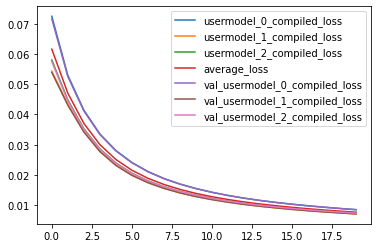

In [6]:
from utils import plot_loss
plot_loss(history)

The loss curves look good.

As you may notice in addition to the loss metrics specified in compalation step ``Capsa`` also logs some additional losses these are computed under the hood to enable this risk aware functionality mentioned earlier.

Let's look at the calibration plot that the model produces to quantitatively assess the quality of the risk estimate.

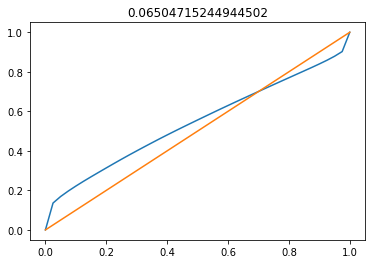

In [7]:
from utils import gen_calibration_plot
gen_calibration_plot(model, ds_test)

##  Anomaly detection

The core idea behind the approach is that a model’s epistemic uncertainty on out-of-distribution (OOD) data is naturally higher than the same model’s epistemic uncertainty on indistribution (ID) data. Thus, given a risk aware model we can visualize density histograms of per image uncertainty estimates provided by a model on both ID (unseen test-set for NYU Depth V2 dataset) and OOD data (MiniPlaces). 

In other words, we would expect that the epistemic uncertainty estimate will help us to separate the out-of-distribution data. 

Let's plot the histogram and see...

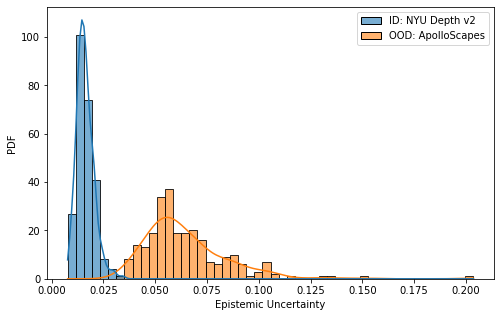

In [8]:
from utils import gen_ood_comparison
iid_risk, ood_risk = gen_ood_comparison(ds_test, ds_ood, model, reduce='per_img', is_show=True, is_return=True)

🤩 Amazing! Indeed, we see that the out-of-distribution datapoints have higher model uncertainty and we see two clearly pronounced peaks corresponding to the different datasets.

At this point, OOD (anomaly) detection is possible by a simple thresholding. We can use AUC-ROC to quantitatively assess the separation of the two density histograms, a higher AUC indicates a better quality of the separation.

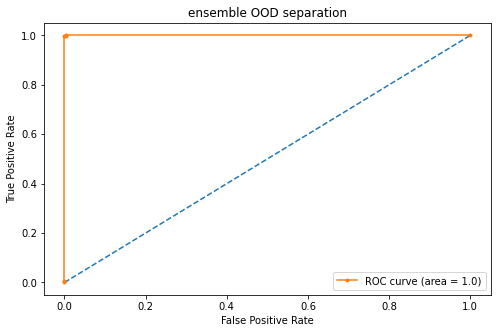

In [9]:
from utils import plot_roc
plot_roc(iid_risk, ood_risk, model.metric_name)

## Adversarial perturbations

Further, the approach described above could be used to detect adversarial attacks (perturbations). A way of interpreting the adversarial perturbations is as a way of gradually turning ID data points into OOD. Such a granular control allows for a better model introspection.

After we've trained the model, we compute gradients with respect to the input image and apply it with varying epsilon.
In other words, the approach is:

```
for each test image, compute gx = dL/dx (the gradient of the loss with respect to the input image pixels)
for different levels of adversarial noise k = [0, ..., 0.1]:
 perturb the test images:  x_new = x_old + k * tf.sign(gx)
 run the model on these images and compute predictions and risk estimate
```

The cell below simply implements the pseudocode above and caches the predictions.

In [10]:
from adversarial import get_adversarial_predictions
df_risk, risk_id, list_risk_ood, list_vis = get_adversarial_predictions(model, ds_test)

Simularly as we did earlier, let's visualize density histograms of per image uncertainty estimates provided by a model on both the test data (in distribution) and the preturbed data (out of distribution).

We see that as the epsilon of the perturbation increases the density histograms of per image uncertainty estimates provided by a model on both the ID and perturbed images become more disentangled and thus the quality of separation increases.

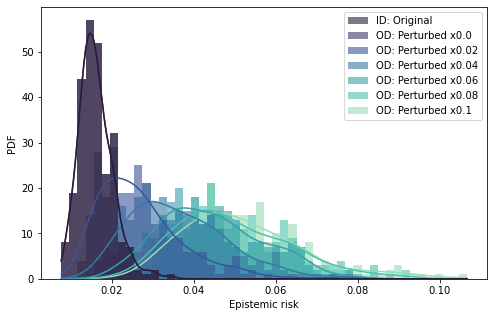

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 5))
plot = sns.histplot(data=df_risk, kde=True, bins=50, alpha=0.6, linewidth=0, palette="mako")
plot.set(xlabel="Epistemic risk", ylabel="PDF")
plt.show()

Simularly as we did earlier let's use AUC-ROC to quantitatively assess the separation of the two density histograms, a higher AUC indicates a better quality of the separation.

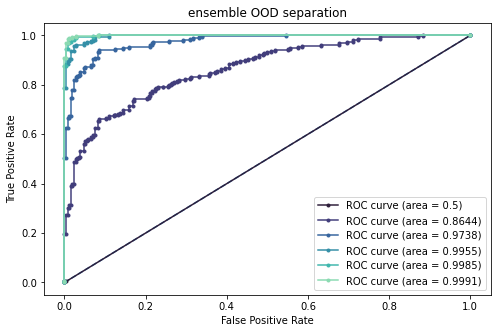

In [12]:
model_name = model.metric_name
plot_roc(risk_id, list_risk_ood, model_name, is_palette=True)

Finally, let's visualize the images perturbed with varying degrees. We plot the input to the model on the first row; model's predictions on the second row; and the risk estimate (outputed by the model) on the third row.

We see that even though some of the perturbed images are not immediately distinguishable to a human eye, the method described above successfully detects the altered input images. We also see that as the more the image becomes an out of distribution, the more the depth estimate degrades. 

Luckily, since our model is risk aware we're able to capture the model's uncertainty in its predictions.

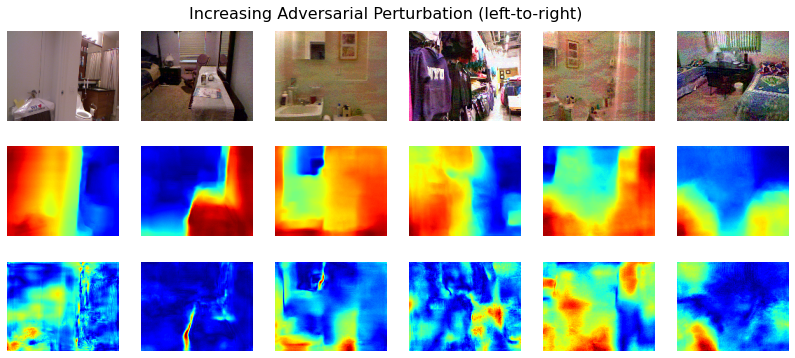

In [13]:
from adversarial import visualize_adversarial
visualize_adversarial(list_vis)